# Notebook pt 2 - Progressing from sky maps to ratio scatter diagrams

# Section 1: Set Up

The first few code samples parallel the previous notebooks, and are explained in Notebook 1.

In [3]:
import aplpy
import numpy as np
from astropy.io import fits
import matplotlib as mpl
import math
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import pandas as pd
from matplotlib.scale import SymmetricalLogTransform, InvertedSymmetricalLogTransform
#from scipy.stats import gaussian_kde
from heapq import nsmallest

In [4]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['patch.linewidth'] = 2
mpl.rcParams['lines.markeredgewidth'] = 2
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['axes.linewidth'] = 2

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['xtick.major.size'] = 10
mpl.rcParams['xtick.major.pad'] = 5
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['xtick.minor.pad'] = 5

mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 10
mpl.rcParams['ytick.minor.size'] = 5

mpl.rcParams['figure.figsize'] = (10, 10/1.6)

In [5]:
MapDust = fits.open(r'C:\Users\natac\Desktop\MIT_internship_2021\fits-files-week-of-June-21st\Herschel_AV_smo60_resa.fits')[0]
MapDust.data[MapDust.data < 2.] = np.nan

MapDustTemperature = fits.open(r'C:\Users\natac\Desktop\MIT_internship_2021\fits-files-week-of-June-21st\Herschel_Tdust_resa.fits')[0]

SymlogScaling = SymmetricalLogTransform(10, 2, 1).transform
InverseSymlogScaling = InvertedSymmetricalLogTransform(10, 2, 1).transform


Map12CO = fits.open(r'C:\Users\natac\Desktop\MIT_internship_2021\fits-files-week-of-June-21st\oriona_12co_XYV_smo60_int-70-125_resa.fits')[0]
Map13CO = fits.open(r'C:\Users\natac\Desktop\MIT_internship_2021\fits-files-week-of-June-21st\oriona_13co_XYV_smo60_int-70-125_resa.fits')[0]
MapC18O = fits.open(r'C:\Users\natac\Desktop\MIT_internship_2021\fits-files-week-of-June-21st\orion_c18o_smo60_int-490-565.fits')[0] 
MapHCN = fits.open(r'C:\Users\natac\Desktop\MIT_internship_2021\fits-files-week-of-June-21st\orion_hcn_smo60_int-440-585.fits')[0]
MapN2Hp = fits.open(r'C:\Users\natac\Desktop\MIT_internship_2021\fits-files-week-of-June-21st\orion_n2hp_smo60_int-450-590.fits')[0]
MapCN = fits.open(r'C:\Users\natac\Desktop\MIT_internship_2021\fits-files-week-of-June-21st\orion_cn_smo60_int-tot.fits')[0]
MapCCH = fits.open(r'C:\Users\natac\Desktop\MIT_internship_2021\fits-files-week-of-June-21st\orion_c2h_smo60_int-470-650.fits')[0]    

In [6]:
NoiseLine = {'12CO': 0.94 * 0.2 * sqrt(125.-70.) * 52.*(100./115.)/60.,
             '13CO': 0.28 * 0.2 * sqrt(125.-70.) * 52.*(100./110.)/60.,
             'C18O': 0.17549,
             'HCN': 0.52463,
             'N2H+': 0.32648,
             'CN': 0.70422,
             'CCH': 0.45627}
for Index in NoiseLine.keys():
    NoiseLine[Index] = NoiseLine[Index]

# Section 2: Raw Data to a Sky map

## Subsection a: Creating the Sky Map

As described in Notebook 1, we now have the raw data of the radiation emitted from the molecules, and need to display this data. The first type of plot we are going to do is a sky map. It is a very simple plot, that illustrates the intensity of the molecule as it apears on the sky. Below are two maps that are very different in how the molecules are concentrated in the sky. 

This first plot shows a concentration of high intenisities in the center of the plot, with relatively high intensity dispersed throughout the cloud. Along the edges the intensity seems to be consistantly zero. 

The second plot shows a line of high intensity spots in the midline of the graph. The rest of the plot seems to have an intensity at or around zero. Three main spots of concentration are featured on the thin line of emission data. 

INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -1.253e+01 [aplpy.core]
INFO: Auto-setting vmax to  1.912e+02 [aplpy.core]


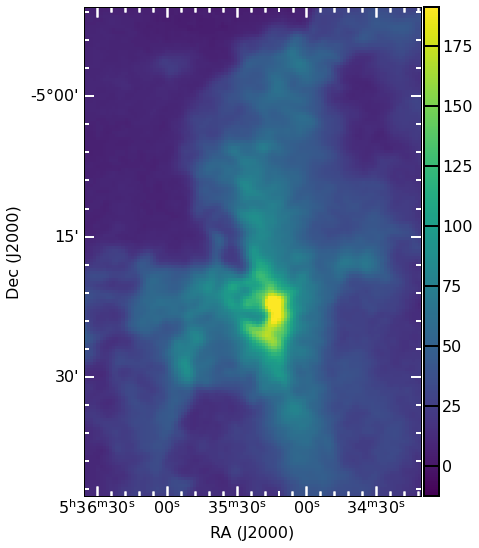

INFO: Setting slices=[0] [aplpy.core]
INFO: Auto-setting vmin to -7.114e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.755e+00 [aplpy.core]


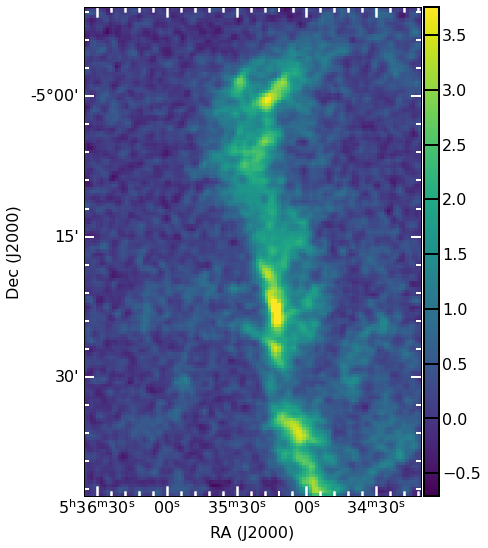

In [7]:
FigLine = aplpy.FITSFigure(Map12CO)
FigLine.show_colorscale()
FigLine.add_colorbar()
plt.show()

FigLine = aplpy.FITSFigure(MapC18O)
FigLine.show_colorscale()
FigLine.add_colorbar()
plt.show()

We can very easily by eye distinguish the differences in the concentrations of the molecules. We can tell which one is more abundant, and in what areas. However, we need a more quantitative way to differentate the molecules. If we were doing this by eye, we would look at the colors and the size of the 'blobs' on each of the maps. To constitute a 'similar' pair of molecules, we would recognize bright and dim spots in the same places in both maps. If Map A is bright in the center, to be similar, Map B must also be bright in the center. The computer does this similarly, but on a pixel by pixel basis. To develop an algorithm to evaluate the similarites and differences between maps, we start by inspecting the line intensities on a scatter diagram 

## Subsection b: Line Intensity Scatter Plot

Scatter plots constitute an alternative way to compare two maps. Every location (i.e. pixel) in the map corresponds to one data point. The intensity of on emission line is used to determine the point's location along the horizontal axis, and the other emission line determines the point's location along the vertical axis. The shape of the scatter plot is a useful way to compare the similarities between the line emissions (x and y axes). 

The first thing we need to do for our line intensity scatter plots is to make the scatter plots into a ratio. We will do this by putting one molecule on the x axis and a separate molecule on the y axis. 

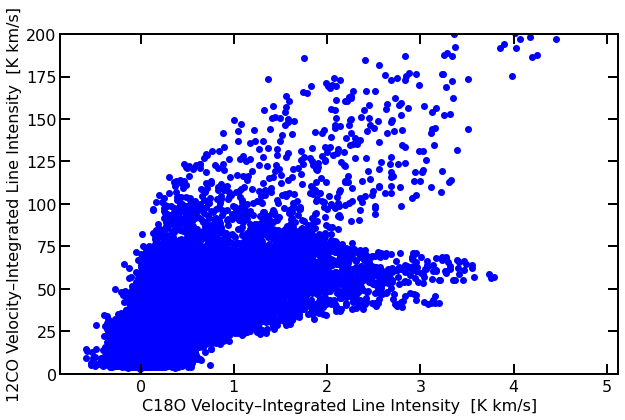

In [8]:
x = MapC18O.data
y = Map12CO.data

plt.figure(1)
ax = plt.subplot(1,1,1)
plt.scatter(x, y,
            marker='.', color='blue')
ax.set_ylim([0, 200])
ax.set_xlabel('C18O Velocity–Integrated Line Intensity  [K km/s]')
ax.set_ylabel('12CO Velocity–Integrated Line Intensity  [K km/s]')

plt.show()

However, it is extremely difficult to see the concentration of the points, so we are going to reduce the transparency of the points. This means that we will be able to see the concentration of the points at spots on the chart. We will set each point to an opacity of 0.2, so in the more concetrated areas it will be a deeper color. 

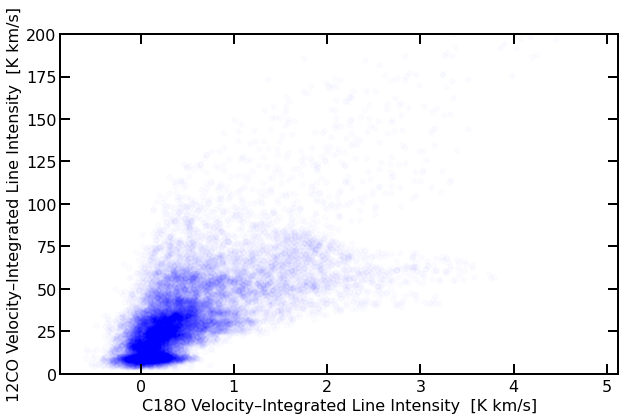

In [9]:
x = MapC18O.data
y = Map12CO.data




plt.figure(1)
ax = plt.subplot(1,1,1)
plt.scatter(x, y,
            marker='.', color='blue', alpha=0.01)
ax.set_ylim([0, 200])
ax.set_xlabel('C18O Velocity–Integrated Line Intensity  [K km/s]')
ax.set_ylabel('12CO Velocity–Integrated Line Intensity  [K km/s]')

plt.show()

# Section 3: Larger Scale

## Subsection a: Selected plots for display

Now that we have the ratio scatter plots in a format we like, we can manually 'play around' with which molecules we are comparing. All of the ratios apear very differently on the scatter diagram. 
We have below a variety of maps

$C^{12}O$ and N2H+. 

In this scatter diagram, we see a large concentration of data points at zero on the y axis and from zero to one hundred on the y axis. The data points furcates into three major forks, with outlying data points in between the forks. This plot does not have a linear correlation, nor does it have a simple one. The plot is moderately coorelated in that the data points are not concentrated on a thin line. The emission lines apear to be dissimilar.

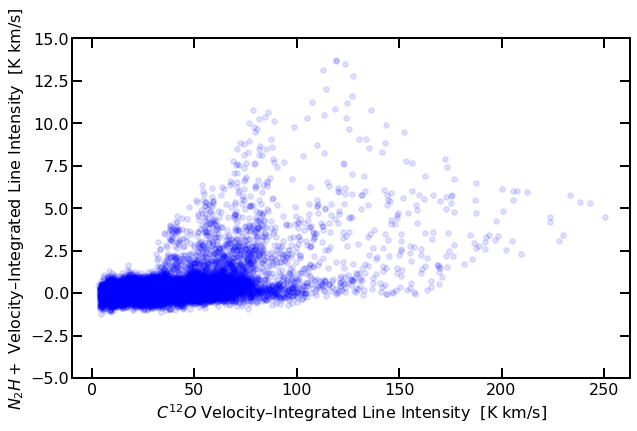

In [10]:
x = Map12CO.data
y = MapN2Hp.data


plt.figure(1)
ax = plt.subplot(1,1,1)
plt.scatter(x, y,
            marker='.', color='blue', alpha=0.1)
ax.set_ylim([-5, 15])
ax.set_xlabel('$C^{12}O$ Velocity–Integrated Line Intensity  [K km/s]')
ax.set_ylabel('$N_2H+$ Velocity–Integrated Line Intensity  [K km/s]')

plt.show()

$C^{18}O$ and HCN

In this scatter plot, the datapoints again are concentrated around zero, and the plot is bifurcated. These forks are a lot more prominant, and there is a stronger coorelation than the previous plot. The plot seems to follow a simple diagonal line, right in between the forks. This suggests that the distribution lines are relatively similar. 

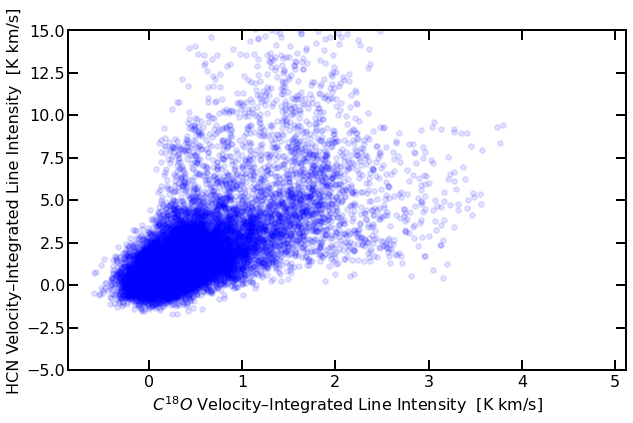

In [11]:
x = MapC18O.data
y = MapHCN.data


plt.figure(1)
ax = plt.subplot(1,1,1)
plt.scatter(x, y,
            marker='.', color='blue', alpha=0.1)
ax.set_ylim([-5, 15])
ax.set_xlabel('$C^{18}O$ Velocity–Integrated Line Intensity  [K km/s]')
ax.set_ylabel('HCN Velocity–Integrated Line Intensity  [K km/s]')

plt.show()

CN and CCH

In this final plot, we have a very strongly and simply coorelated scatter diagram. All of the points follow one thin line, and the concentration of these points diffuse as the plot moves along the x axis. This all suggests that the plots are similar.

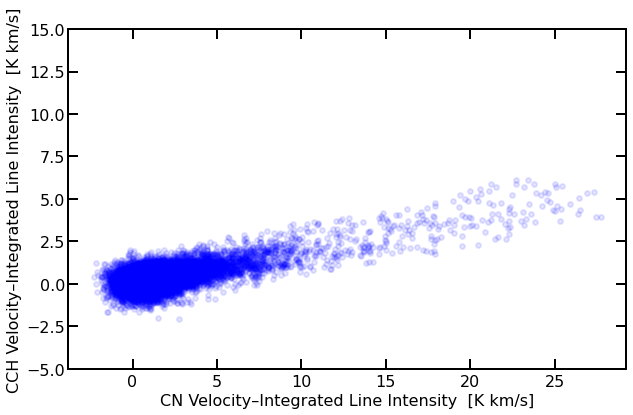

In [12]:
x = MapCN.data
y = MapCCH.data



plt.figure(1)
ax = plt.subplot(1,1,1)
plt.scatter(x, y,
            marker='.', color='blue', alpha=0.1)
ax.set_ylim([-5, 15])
ax.set_xlabel('CN Velocity–Integrated Line Intensity  [K km/s]')
ax.set_ylabel('CCH Velocity–Integrated Line Intensity  [K km/s]')

plt.show()

## Subsection b: Autonomize Production of Ratio Scatter Plots

Now that we know how to make the ratio scatter plots in the format we like, we are going to autonomize the production of these plots. The first thing that we will do is to set up a dictionary of all of the information.

In [13]:
data_dictionary = [
{"data_set": Map12CO.data,"title": '$^{12}CO$' , "standardized_color": 'pink' , "noiseline": 1.05073560014},
{"data_set": Map13CO.data, "title": '$^{13}CO$' , "standardized_color": 'red' , "noiseline": 0.3272},
{"data_set": MapC18O.data, "title": '$C^{18}O$' , "standardized_color": 'orange' , "noiseline": 0.17549},
{"data_set": MapN2Hp.data, "title": '$N_2H^+$' , "standardized_color": 'brown' , "noiseline": 0.32648},
{"data_set": MapHCN.data, "title": 'HCN' , "standardized_color": 'blue' , "noiseline": 0.52463},
{"data_set": MapCN.data, "title": 'CN' , "standardized_color": 'green' , "noiseline": 0.70422},
{"data_set": MapCCH.data, "title": 'CCH' , "standardized_color": 'purple' , "noiseline": 0.45627}]


for x_index in range(len(data_dictionary)):
    data_dictionary[x_index]['brightness'] = np.sum((data_dictionary[x_index]['data_set'] / data_dictionary[x_index]['noiseline']) > 3)
    #print(data_dictionary[x_index]['brightness'])

    
list_of_x = sorted(data_dictionary, key=lambda d: d['brightness'], reverse=True) 

for x_index in range(len(list_of_x)):
    print(str(list_of_x[x_index]['title']) + "    ===>    " + str(list_of_x[x_index]['brightness']))

$^{12}CO$    ===>    16955
$^{13}CO$    ===>    15386
HCN    ===>    7033
$C^{18}O$    ===>    5556
CN    ===>    4039
$N_2H^+$    ===>    1440
CCH    ===>    882


Next we will make a function that basically contains the same information as the cells above, however the difference is that we are setting the titles and data as a section of the dictionary, so the program will move through the dictionary and pull the correct information.

In [20]:
def plot_scatter_plots(x_array, y_array):
    NumberBinsX = 180
    NumberBinsY = 90
    BinTransparencyThreshold = 2
    
    x_data = x_array['data_set']
    y_data = y_array['data_set']

    x_title = x_array['title']
    y_title = y_array['title']
    x_label = x_array['title']
    y_label = y_array['title']
    x_color = x_array['standardized_color']
    y_color = y_array['standardized_color']


    x_flat = x_data.flatten()
    y_flat = y_data.flatten() 
    
    plt.figure(1)
    ax = plt.subplot(1,1,1)
    plt.scatter(x_data, y_data,
            marker='.', color='blue', alpha = 0.1)
    
    title_text = x_title + ' and ' + y_title
    plt.title(title_text)
    
    
    ax.set_xlabel(x_label + " Velocity–Integrated Line Intensity  [K km/s]")
    ax.set_ylabel(y_label + " Velocity–Integrated Line Intensity  [K km/s]")
    
    plt.show()

As we look at the plots, we will see a great diversity in how the plots apear. In the next notebook, we will address how to more quantitatively categorize these plots.

Lastly we are going to make a 'for loop' to make sure that the program is not printing the same pairing of molecules multiple times. We append the pair of molcules that we just done to our array 'already_done'.

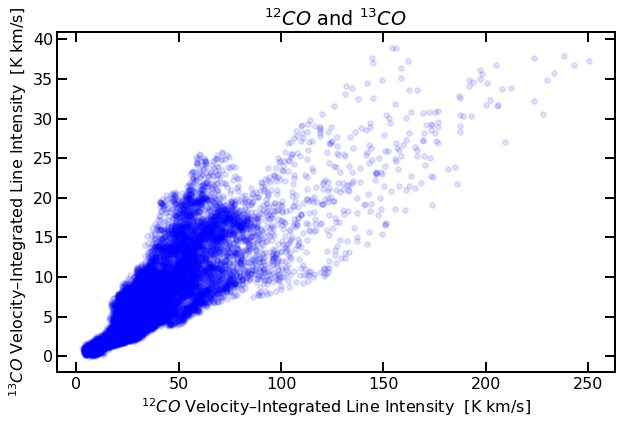

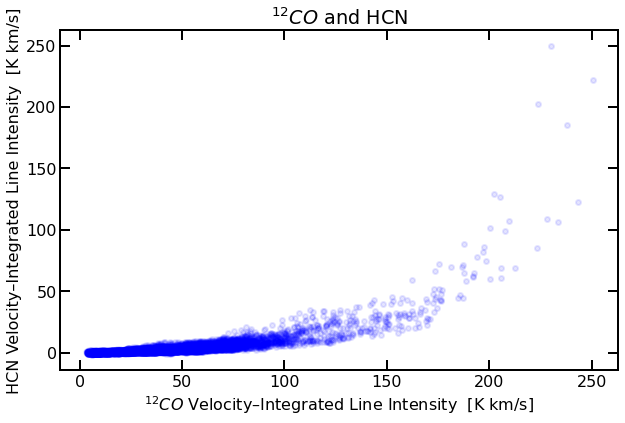

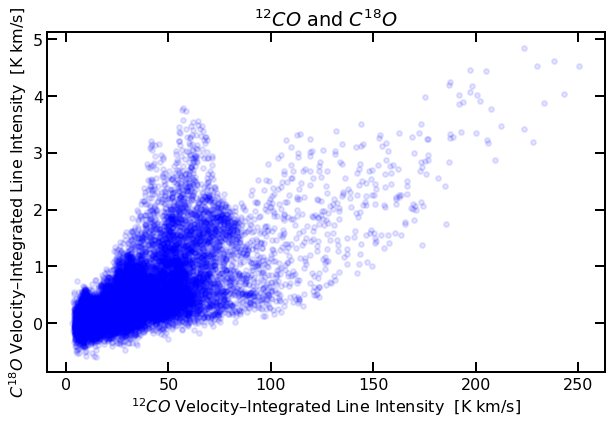

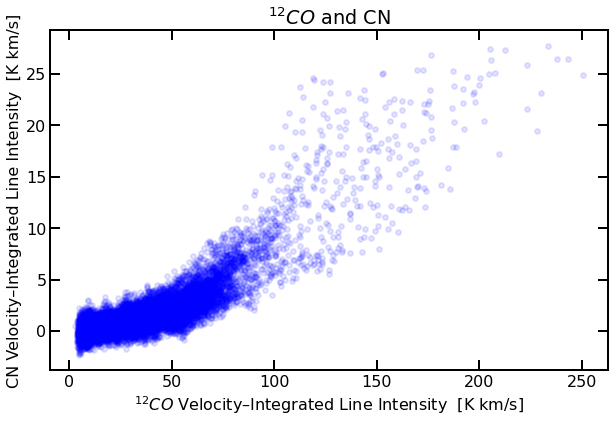

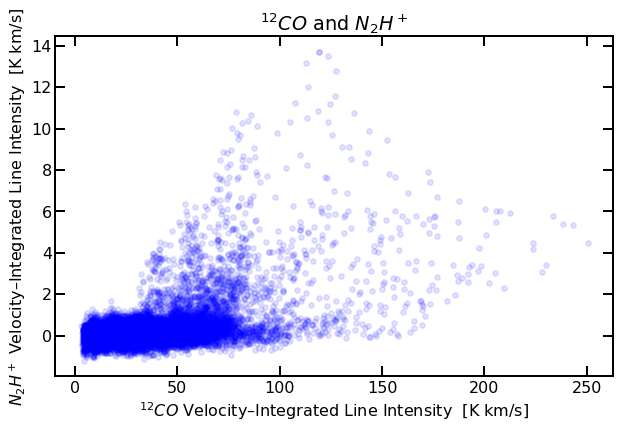

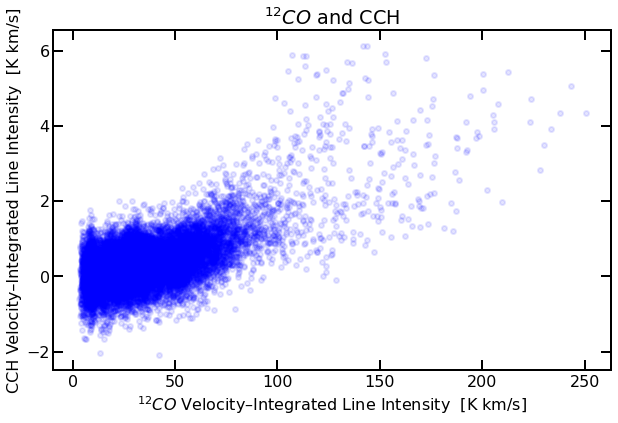

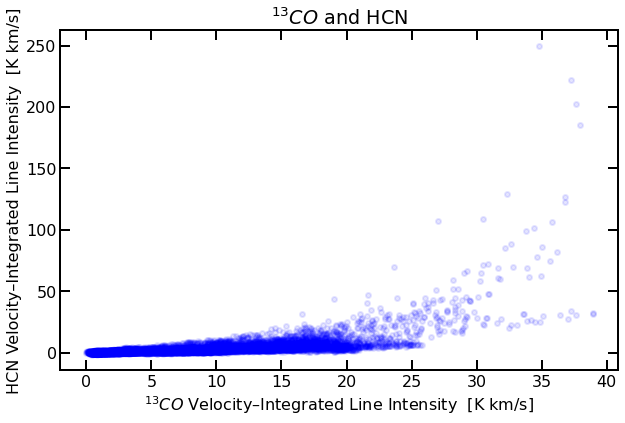

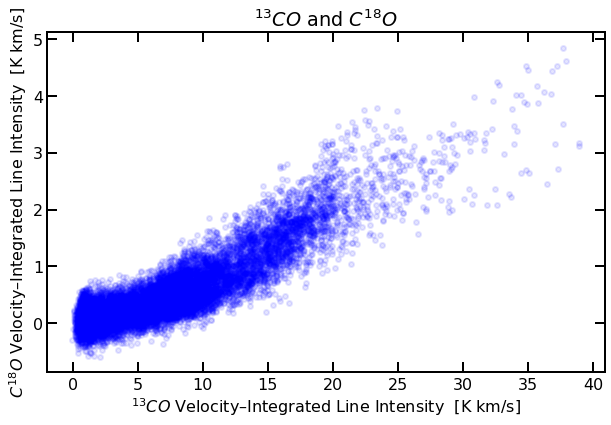

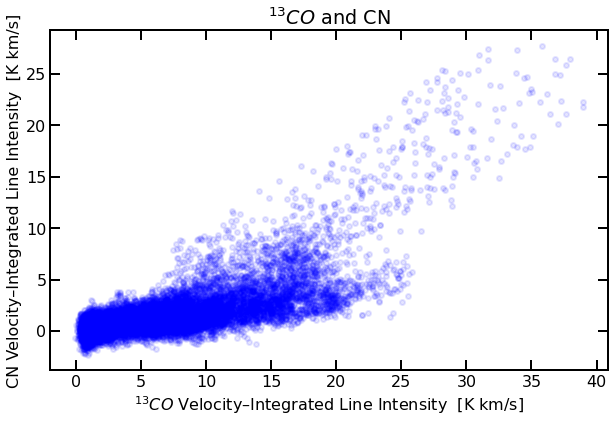

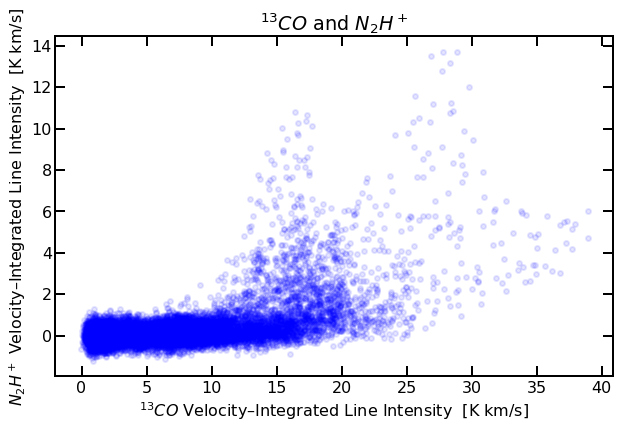

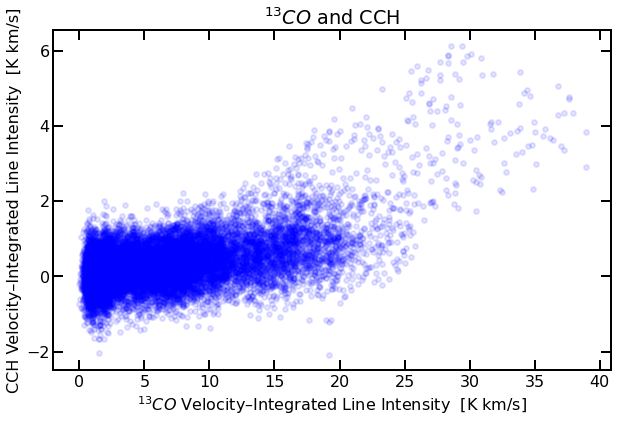

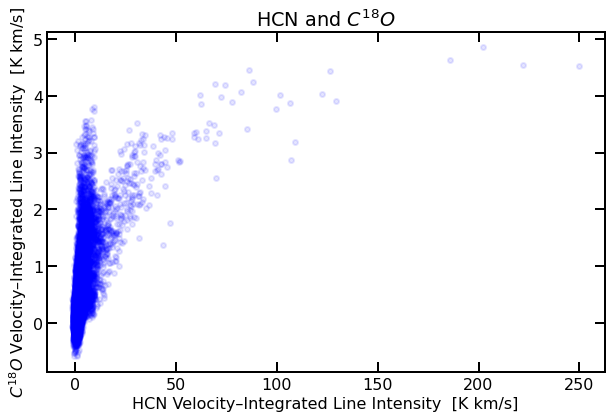

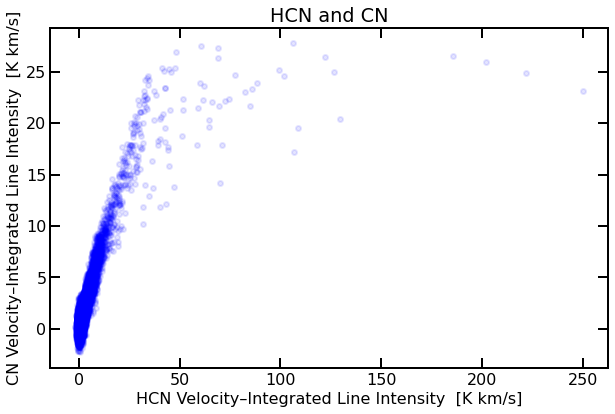

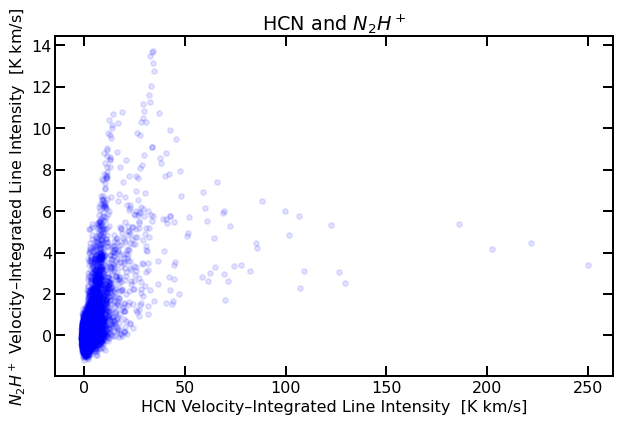

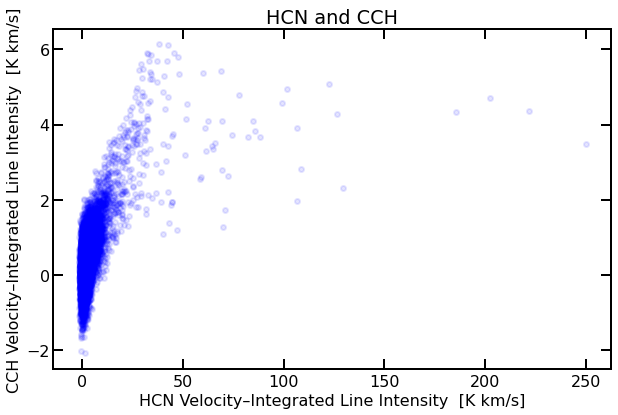

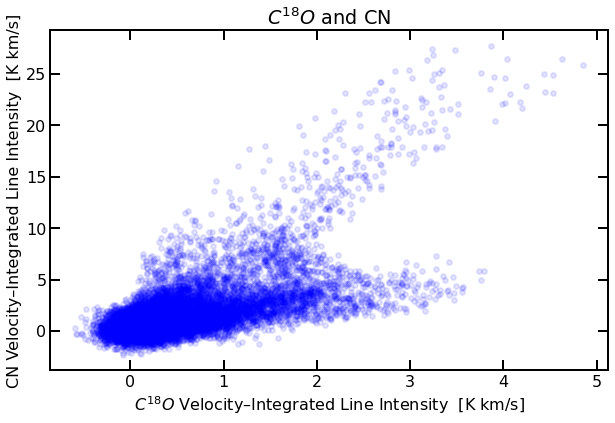

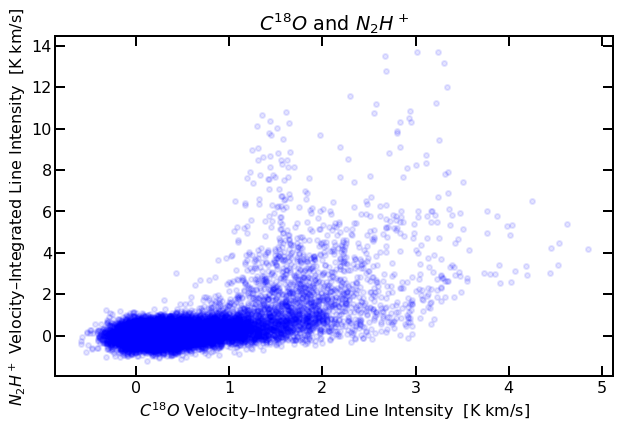

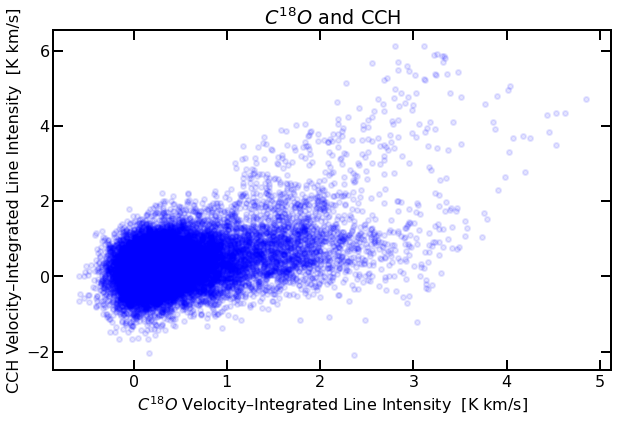

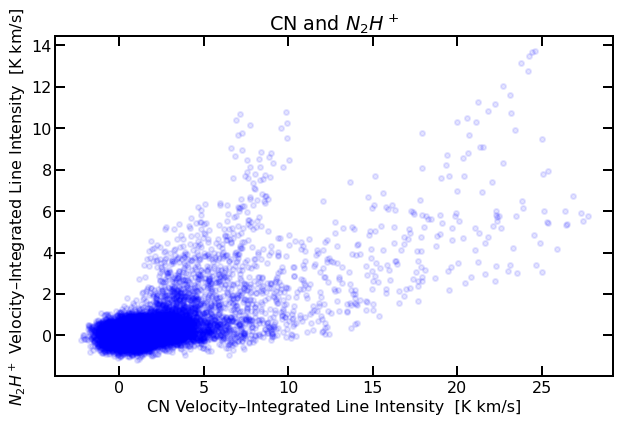

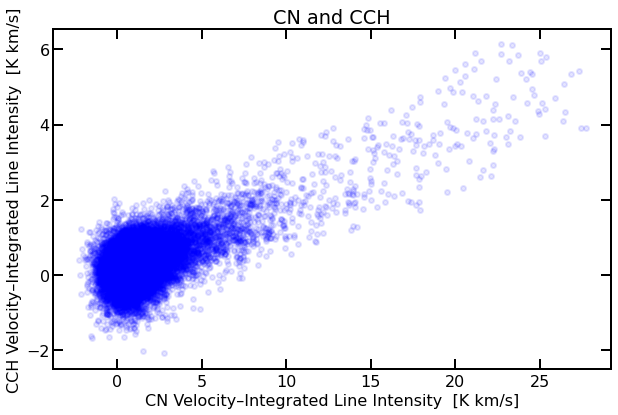

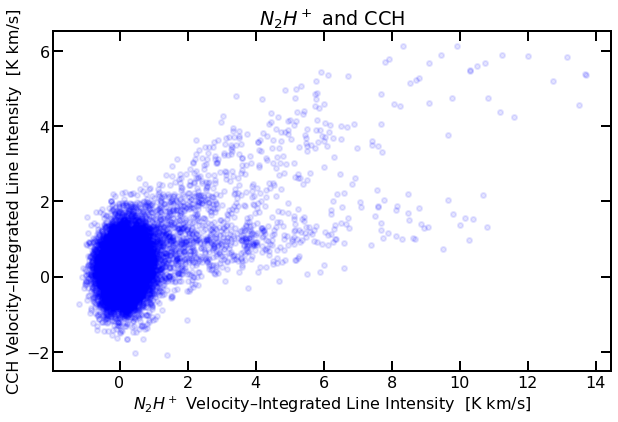

In [21]:
already_done = []

for x in list_of_x:

    for y in list_of_x:
        if x['title'] == y['title']: pass
        elif [x['title'],y['title']] in already_done or [y['title'],x['title']] in already_done: pass
        else: 
            plot_scatter_plots(x, y)
            already_done.append([x['title'],y['title']])
            
    print("=========================")
